# Explainer Jupyter Notebook
### A Copenhagen Data Story - Inequality in Health and Wealth
Technical University of Denmark

02806 Social Data Analysis and Visualization

May 12, 2023
* Søren Blatt Bendtsen
* Vivién Varadi
* Thomas Adamopoulos

# 1. Motivation

As also mentioned in the article, our motivation to deap dive further into health and wealth in Copenhagen came from discussions on different views on life in Copenhagen. We were very motivated to look further into actual topics that we notice in our everyday life of living in Copenhagen. 

We have gathered our data set from the tool Velstand & Ulighed created by Rockwool Fonden. Rockwool Fonden uses data delivered by Danmark Statistik (DST) from their administrative register. The underlying data is therefore row based on individual people living in Denmark identifiable by their CPR-number [1]. The data publicly available to download from Rockwool Fonden's tool is aggregated on a yearly base for groups of the population.

First of all, as this project is for the class "Social Data Analysis and Visualization", we wanted to have a social aspect on the project. And working with inequality has just that. Second of all, we chose to work with this specific data set as it has several interesting continous numerical attributes, as well as interesting demographic categorical attributes, that we imagined to find interesting trends within. We decided to work with the 20 municipalities located in the greater region of Copenhagen, as well as an average for the whole of Denmark.

Our goal with this project was to bring facts into a discussion that is very often based on assumptions, opinions and what you are used to hearing in the news. We, among ourselves in the group, had discussions based on experience, and we believed that looking at the actual data within these topics, would bring a deeper dimension to our discussion. For the end user of the article, we wanted to create an article with interactive visualizations, where we would highlight the most important aspects, but that at the same time would allow the user dig down even further in the data.

# 2. Basic stats and data preparation

Quite a lot of data preparation and cleaning was required to create the final data set that we have worked on. This work has been done in four separate Jupyter Notebooks, as it required many lines of code. Among other things, the following have been done.

* From the tool Velstand & Ulighed, we decided to download data sets for disposable income, number of days spent in the hospital and number of hospitalizations. Only small chunks of data could be downloaded at the time for small group of years, municipalities, ages, genders, educations and ethnicities and therefore many small data sets had to be merged together.
* When downloading the data sets, the demographic variables were not named. This therefore had to be done for each small data set before merging them together.
* Remove duplicates. Every chunk of data included an average for the total Denmark. Duplicates of this have been moved.
* Translation from Danish to English
* Matching of municipality code to actual municipality name
* Weighted calculations: as the data is on an aggregated basis, we had to use the number of observations (included from Velstand & Ulighed) within each group in order to calculate a variety of weighted numbers, that can then be used when grouping by a combination of different variables.
* Calculate Greater Copenhagen average. We wanted to compare the whole of Denmark to Copenhagen. For that reason we have calculated weighted averages for the Greater Copenhagen Region based on data from the 20 municipalities within Copenhagen.
* Select relevant columns

After doing the above work for the data sets related to Income, Days in Hospital and Number of Hospitalizations, they have at last been merged together to one complete data set called copenhagen_data.csv.

In [126]:
# import libraries
# Used for working with dataframes and visualizing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [98]:
# Load data set and save to data frame
df = pd.read_csv('copenhagen_data.csv')

At this point, we realized that there was many rows with Null Values. This was due to the data for Income, Days in Hospital and Number of Hospitalizations not being available for the same number of years and demographic groups. For that reason we are dropping missing values below.

In [ ]:
# Drop rows with missing values
df_2= df.dropna()
df_dk = df_2[df_2.municipality == 'Denmark']
df_cph = df_2[df_2.municipality == 'Greater Copenhagen']

Why do we do one-hot encoding? And what is the purpose of the following box-plots? 

Let's consider what we include and show here. I think some plots of distributions etc. is a good idea, but let's consider what makes sence.

In [5]:
# Perform one-hot encoding on the 'gender' column
one_hot_encoded_gender = pd.get_dummies(df.gender, prefix='gender')

# Concatenate the one-hot encoded columns to the original DataFrame
df_gender = pd.concat([df.drop('gender', axis=1), one_hot_encoded_gender], axis=1)
df_gender


,municipality,municipality code,year,age,ethnicity,education,income,income observations,weighted_inc_mun,days in hospital,days in hospital observations,weighted_hosp_days_mun,number of hospitalizations,number of hospitalizations observations,weighted_hospitalizations_mun,gender_Men,gender_Women
0,Denmark,0,2005,18-29,Danish,Higher education,NaN,NaN,NaN,0.186,30425.0,0.001379,0.049,30425.0,0.000364,1,0
1,Denmark,0,2005,18-29,Danish,No higher education,NaN,NaN,NaN,0.269,296267.0,0.019420,0.076,296267.0,0.005493,1,0
2,Denmark,0,2005,18-29,Immigrants and descendants,Higher education,NaN,NaN,NaN,0.159,1925.0,0.000075,0.047,1925.0,0.000022,1,0
3,Denmark,0,2005,18-29,Immigrants and descendants,No higher education,NaN,NaN,NaN,0.256,26048.0,0.001625,0.078,26048.0,0.000496,1,0
4,Denmark,0,2005,18-29,Non-western immigrants and descendants,Higher education,NaN,NaN,NaN,0.155,1096.0,0.000041,0.047,1096.0,0.000013,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39600,Greater Copenhagen,1,2020,60-65,Danish,No higher education,327995.938342,19143.0,9789.862554,NaN,NaN,NaN,NaN,NaN,NaN,0,1
39601,Greater Copenhagen,1,2020,60-65,Immigrants and descendants,Higher education,360832.894995,1075.0,604.801301,NaN,NaN,NaN,NaN,NaN,NaN,0,1
39602,Greater Copenhagen,1,2020,60-65,Immigrants and descendants,No higher education,233379.566602,2257.0,821.282403,NaN,NaN,NaN,NaN,NaN,NaN,0,1
39603,Greater Copenhagen,1,2020,60-65,Non-western immigrants and descendants,Higher education,258666.804848,369.0,148.821334,NaN,NaN,NaN,NaN,NaN,NaN,0,1


In [6]:
women_dk = df[(df.gender == 'Women') & (df.municipality == 'Denmark')]
women_cph = df[(df.gender == 'Women') & (df.municipality == 'Greater Copenhagen')]

In [7]:
women_cph.isnull().sum()

municipality                                 0
municipality code                            0
year                                         0
gender                                       0
age                                          0
ethnicity                                    0
education                                    0
income                                      84
income observations                         84
weighted_inc_mun                            84
days in hospital                           480
days in hospital observations              480
weighted_hosp_days_mun                     480
number of hospitalizations                 480
number of hospitalizations observations    480
weighted_hospitalizations_mun              480
dtype: int64

In [8]:
women_dk.isnull().sum()

municipality                                 0
municipality code                            0
year                                         0
gender                                       0
age                                          0
ethnicity                                    0
education                                    0
income                                      84
income observations                         84
weighted_inc_mun                            84
days in hospital                           480
days in hospital observations              480
weighted_hosp_days_mun                     480
number of hospitalizations                 480
number of hospitalizations observations    480
weighted_hospitalizations_mun              480
dtype: int64

In [9]:
women_dk.describe()

,municipality code,year,income,income observations,weighted_inc_mun,days in hospital,days in hospital observations,weighted_hosp_days_mun,number of hospitalizations,number of hospitalizations observations,weighted_hospitalizations_mun
count,900.0,900.000000,816.000000,816.000000,816.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,0.0,2004.246667,231148.001544,50582.045343,5242.652856,0.688081,73545.061905,0.016225,0.175255,73545.061905,0.003613
std,0.0,9.711021,54344.204847,75442.268114,7776.173635,0.523846,115823.896253,0.047336,0.076952,115823.896253,0.008649
min,0.0,1987.000000,132744.213000,95.000000,10.842936,0.146000,739.000000,0.000136,0.064000,739.000000,0.000046
25%,0.0,1996.000000,187093.794000,3094.000000,273.547178,0.360750,6866.750000,0.000811,0.124750,6866.750000,0.000226
50%,0.0,2005.000000,223897.277000,8358.500000,754.998928,0.487000,15870.500000,0.001970,0.153000,15870.500000,0.000608
75%,0.0,2013.000000,262636.062750,92572.500000,10046.301530,0.733500,119248.000000,0.011903,0.184000,119248.000000,0.003465
max,0.0,2020.000000,432689.526000,271526.000000,28641.438926,2.549000,566835.000000,0.293683,0.408000,566835.000000,0.051088


In [10]:
women_cph.describe()

,municipality code,year,income,income observations,weighted_inc_mun,days in hospital,days in hospital observations,weighted_hosp_days_mun,number of hospitalizations,number of hospitalizations observations,weighted_hospitalizations_mun
count,900.0,900.000000,816.000000,816.000000,816.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,1.0,2004.246667,227421.468557,12102.427696,5495.549291,0.748357,18396.780952,0.016753,0.187238,18396.780952,0.003720
std,0.0,9.711021,73910.812681,16153.552222,7530.139170,0.649131,23544.299073,0.046669,0.092704,23544.299073,0.007929
min,1.0,1987.000000,0.000000,0.000000,0.000000,0.142508,189.000000,0.000116,0.070749,189.000000,0.000040
25%,1.0,1996.000000,183312.118565,934.250000,362.998452,0.349352,2943.250000,0.001316,0.127060,2943.250000,0.000420
50%,1.0,2005.000000,219904.990893,3262.000000,1232.432108,0.496680,6892.000000,0.003411,0.159697,6892.000000,0.001144
75%,1.0,2013.000000,269361.221787,22497.750000,10117.321605,0.756136,29409.000000,0.013196,0.200414,29409.000000,0.003842
max,1.0,2020.000000,481647.943619,58907.000000,27843.156313,3.033039,104615.000000,0.304670,0.505179,104615.000000,0.046701


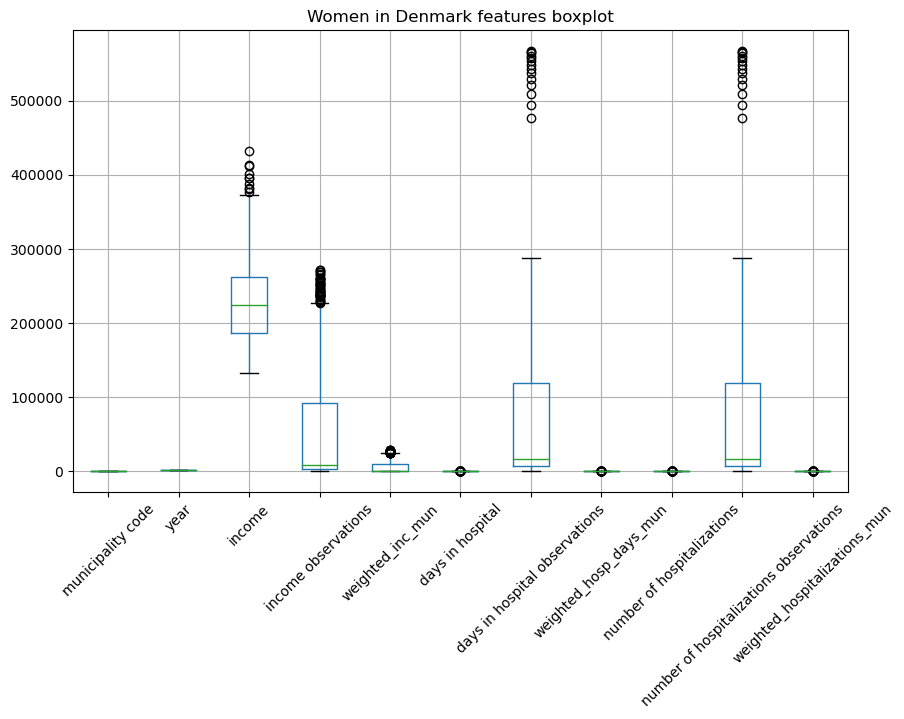

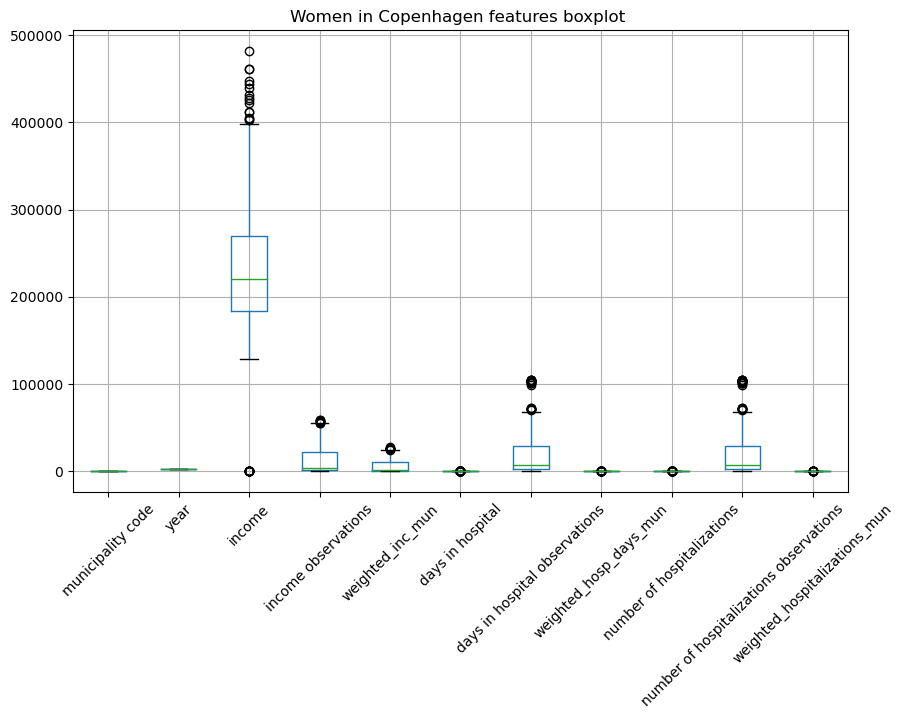

In [11]:
plt.figure(figsize= (10,6))
women_dk.boxplot()
plt.xticks(rotation=45)
plt.title('Women in Denmark features boxplot')
plt.show()

plt.figure(figsize= (10,6))
women_cph.boxplot()
plt.xticks(rotation=45)
plt.title('Women in Copenhagen features boxplot ')
plt.show()

In [12]:
women_dk_drop = women_dk.dropna()
women_cph_drop = women_cph.dropna()

In [103]:
df_2= df.dropna()
df_dk = df_2[df_2.municipality == 'Denmark']
df_cph = df_2[df_2.municipality == 'Greater Copenhagen']

,municipality,municipality code,year,gender,age,ethnicity,education,income,income observations,weighted_inc_mun,...,weighted_days_age_mun,weighted_days_eth_mun,weighted_days_edu_mun,number of hospitalizations,number of hospitalizations observations,weighted_hospitalizations_mun,weighted_hosp_gen_mun,weighted_hosp_age_mun,weighted_hosp_eth_mun,weighted_hosp_edu_mun
6,Denmark,0,2005,Men,30-39,Danish,Higher education,271510.362,98566.0,10707.481497,...,0.028632,0.005907,0.023621,0.056,103551.0,0.001415,0.002864,0.007458,0.001539,0.006177
7,Denmark,0,2005,Men,30-39,Danish,No higher education,218419.246,229065.0,20018.126583,...,0.123671,0.025516,0.030419,0.096,249125.0,0.005835,0.011811,0.030758,0.006346,0.007568
8,Denmark,0,2005,Men,30-39,Immigrants and descendants,Higher education,220190.110,5813.0,512.120219,...,0.001691,0.006485,0.001395,0.062,6508.0,0.000098,0.000199,0.000519,0.001990,0.000430
9,Denmark,0,2005,Men,30-39,Immigrants and descendants,No higher education,169031.486,14256.0,964.137750,...,0.007378,0.028302,0.001815,0.094,15981.0,0.000366,0.000742,0.001932,0.007411,0.000475
10,Denmark,0,2005,Men,30-39,Non-western immigrants and descendants,Higher education,190374.958,3201.0,243.819977,...,0.001208,0.007099,0.000997,0.079,3532.0,0.000068,0.000138,0.000359,0.002188,0.000297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,Denmark,0,2018,Women,60-65,Danish,No higher education,287411.536,118749.0,13983.567277,...,0.660747,0.248846,0.310743,0.379,566835.0,0.046714,0.092133,0.143862,0.053739,0.067189
864,Denmark,0,2018,Women,60-65,Immigrants and descendants,Higher education,321121.430,3182.0,418.652110,...,0.007328,0.030444,0.007826,0.260,9948.0,0.000562,0.001109,0.001732,0.007137,0.001846
865,Denmark,0,2018,Women,60-65,Immigrants and descendants,No higher education,221294.912,5924.0,537.118731,...,0.018636,0.077424,0.008764,0.346,18113.0,0.001363,0.002688,0.004197,0.017294,0.001960
866,Denmark,0,2018,Women,60-65,Non-western immigrants and descendants,Higher education,261165.446,1252.0,133.968861,...,0.001712,0.010264,0.001828,0.241,2768.0,0.000145,0.000286,0.000447,0.002793,0.000476


In [14]:
df2_dk_income_per_year = df_dk.groupby('year')['weighted_inc_mun'].sum().reset_index(name='count')
df2_cph_income_per_year = df_cph.groupby('year')['weighted_inc_mun'].sum().reset_index(name='count')

In [ ]:
dk_income_per_year = df_dk.groupby('year')['weighted_inc_mun'].sum().reset_index(name='count')
cph_income_per_year = df_cph.groupby('year')['weighted_inc_mun'].sum().reset_index(name='count')

dk_income_per_year


# 3. Data analysis

Describe your data analysis and explain what you've learned about the dataset.
If relevant, talk about your machine-learning.

# 4. Genre
Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

# 5. Visualizations

Explain the visualizations you've chosen.
Why are they right for the story you want to tell?

## 5.1 Plotting timelines - Greater Copenhagen vs Denmark

In [104]:
# Data frame with Greater Copenhagen and Denmark
df_cop_dk = df_2[(df_2.municipality == 'Denmark') | (df_2.municipality == 'Greater Copenhagen')]

# unique years and municipalities for plotting
years = df_cop_dk.year.unique()
municipalities = df_cop_dk.municipality.unique()

# Yearly average income
dk_yearly_avg_inc = df_cop_dk[(df_cop_dk.municipality=='Denmark')].groupby(['year', 'municipality'])['weighted_inc_mun'].sum()
cop_yearly_avg_inc = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen')].groupby(['year', 'municipality'])['weighted_inc_mun'].sum()
df_income = df_cop_dk.groupby(['year', 'municipality'])['weighted_inc_mun'].sum().reset_index(name='count')

# Yearly average days in hospital
dk_yearly_avg_hosp_days = df_cop_dk[(df_cop_dk.municipality=='Denmark')].groupby(['year', 'municipality'])['weighted_hosp_days_mun'].sum()
cop_yearly_avg_hosp_days = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen')].groupby(['year', 'municipality'])['weighted_hosp_days_mun'].sum()
df_days = df_cop_dk.groupby(['year', 'municipality'])['weighted_hosp_days_mun'].sum().reset_index(name='count')

# Yearly average hospitalizations
dk_yearly_avg_hosp_times = df_cop_dk[(df_cop_dk.municipality=='Denmark')].groupby(['year', 'municipality'])['weighted_hospitalizations_mun'].sum()
cop_yearly_avg_hosp_times = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen')].groupby(['year', 'municipality'])['weighted_hospitalizations_mun'].sum()
df_hosp = df_cop_dk.groupby(['year', 'municipality'])['weighted_hospitalizations_mun'].sum().reset_index(name='count')

### Interactive visualization for income with filters for age, gender, education and ethnicity

In [110]:
# Create the initial plot
fig = go.Figure()
# Line plot (commented out)
#fig = px.line(df_income, x='year', y='count', color='municipality', markers=True, width=900, height=400)
#fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
#fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))
# Bar plot 
fig.add_trace(go.Bar(x=years,
                y=dk_yearly_avg_inc,
                name='Denmark',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=years,
                y=cop_yearly_avg_inc,
                name='Greater Copenhagen',
                marker_color='rgb(26, 118, 255)'
                ))

# Define the dropdown menu
genders = df_cop_dk.gender.unique()
buttons = []
# Add button for all genders
buttons.append(dict(method='update',
                    label='Gender',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_inc, cop_yearly_avg_inc],
                           'visible': [True]*2}],
                    )
             )


# Add button for each gender
for gender in genders:
    dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_inc_gen_mun'].sum()
    cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_inc_gen_mun'].sum()
    buttons.append(dict(method='update',
                        label=gender,
                        args=[{'x': [years]*2,
                               'y': [dk_yearly_avg_count, cop_yearly_avg_count],
                               'visible': [True]*2}],
                        )
                        # add selection to the list of visible values
                        
                 )

# Define the dropdown menu for Age
ages = df_cop_dk.age.unique()
buttons_2 = []
# Add button for all ages
buttons_2.append(dict(method='update',
                    label='Age',
                    args=[{'x': [years]*4,
                           'y': [dk_yearly_avg_inc, cop_yearly_avg_inc],
                           'visible': [True]*4}],
                    )
             )
# Add button for each age
for age in ages:
    age_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_inc_age_mun'].sum()
    age_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_inc_age_mun'].sum()
    buttons_2.append(dict(method='update',
                        label=age,
                        args=[{'x': [years]*4,
                               'y': [age_dk_yearly_avg_count, age_cop_yearly_avg_count],
                               'visible': [True]*4}],
                        )
                 )
    
# Define the dropdown menu for ethnicity
ethnicities = df_cop_dk.ethnicity.unique()
buttons_3 = []
# Add button for all ethnicities
buttons_3.append(dict(method='update',
                    label='Ethnicity',
                    args=[{'x': [years]*3,
                           'y': [dk_yearly_avg_inc, cop_yearly_avg_inc],
                           'visible': [True]*3}],
                    )
             )
# Add button for each ehtnicity
for ethnicity in ethnicities:
    eth_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_inc_eth_mun'].sum()
    eth_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_inc_eth_mun'].sum()
    buttons_3.append(dict(method='update',
                        label=ethnicity,
                        args=[{'x': [years]*3,
                               'y': [eth_dk_yearly_avg_count, eth_cop_yearly_avg_count],
                               'visible': [True]*3}],
    )
                       )
    
# Define the dropdown menu for education
educations = df_cop_dk.education.unique()
buttons_4 = []
# Add button for all educations
buttons_4.append(dict(method='update',
                    label='Education',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_inc, cop_yearly_avg_inc],
                           'visible': [True]*2}],
                    )
             )
# Add button for each education
for education in educations:
    edu_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_inc_edu_mun'].sum()
    edu_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_inc_edu_mun'].sum()
    buttons_4.append(dict(method='update',
                        label=education,
                        args=[{'x': [years]*2,
                               'y': [edu_dk_yearly_avg_count, edu_cop_yearly_avg_count],
                               'visible': [True]*2}],
    )
                       )

updatemenus = [{'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'active': 0,
                'y': 1.13,
                'x': 0.15}, 
                {'buttons': buttons_2,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.27}, 
                 {'buttons': buttons_3,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.68},
                 {'buttons': buttons_4,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.92}]


# Update the layout to add the dropdown menu and set the title
fig.update_layout(
    updatemenus=updatemenus,
    title='<b>Annual dissposable income by gender, age, education or ethnicity<b>',
    xaxis_tickfont_size=14,
    xaxis=dict(
              title='',
              titlefont_size=16,
              domain=[0, 1],
    ),
    # fix the yaxis range to be the same for all plots
    yaxis=dict(
        title='<b>Income<b>',
        titlefont_size=16,
        tickfont_size=14,
        range=[200000, 390000],
    ),
    legend=dict(
        title='',
        x=0.01,
        y=1,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.write_html('dk_cph_income_bar.html')
fig.show()

### Interactive visualization for days in hospital with filters for age, gender, education and ethnicity

In [111]:
# Create the initial plot
fig = go.Figure()
# Line plot (commented out)
#fig = px.line(df_income, x='year', y='count', color='municipality', markers=True, width=900, height=400)
#fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
#fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))
# Bar plot 
fig.add_trace(go.Bar(x=years,
                y=dk_yearly_avg_hosp_days,
                name='Denmark',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=years,
                y=cop_yearly_avg_hosp_days,
                name='Greater Copenhagen',
                marker_color='rgb(26, 118, 255)'
                ))

# Define the dropdown menu
genders = df_cop_dk.gender.unique()
buttons = []
# Add button for all genders
buttons.append(dict(method='update',
                    label='Gender',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_hosp_days, cop_yearly_avg_hosp_days],
                           'visible': [True]*2}],
                    )
             )


# Add button for each gender
for gender in genders:
    dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_days_gen_mun'].sum()
    cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_days_gen_mun'].sum()
    buttons.append(dict(method='update',
                        label=gender,
                        args=[{'x': [years]*2,
                               'y': [dk_yearly_avg_count, cop_yearly_avg_count],
                               'visible': [True]*2}],
                        )
                        # add selection to the list of visible values
                        
                 )

# Define the dropdown menu for Age
ages = df_cop_dk.age.unique()
buttons_2 = []
# Add button for all ages
buttons_2.append(dict(method='update',
                    label='Age',
                    args=[{'x': [years]*4,
                           'y': [dk_yearly_avg_hosp_days, cop_yearly_avg_hosp_days],
                           'visible': [True]*4}],
                    )
             )
# Add button for each age
for age in ages:
    age_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_days_age_mun'].sum()
    age_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_days_age_mun'].sum()
    buttons_2.append(dict(method='update',
                        label=age,
                        args=[{'x': [years]*4,
                               'y': [age_dk_yearly_avg_count, age_cop_yearly_avg_count],
                               'visible': [True]*4}],
                        )
                 )
    
# Define the dropdown menu for ethnicity
ethnicities = df_cop_dk.ethnicity.unique()
buttons_3 = []
# Add button for all ethnicities
buttons_3.append(dict(method='update',
                    label='Ethnicity',
                    args=[{'x': [years]*3,
                           'y': [dk_yearly_avg_hosp_days, cop_yearly_avg_hosp_days],
                           'visible': [True]*3}],
                    )
             )
# Add button for each ehtnicity
for ethnicity in ethnicities:
    eth_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_days_eth_mun'].sum()
    eth_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_days_eth_mun'].sum()
    buttons_3.append(dict(method='update',
                        label=ethnicity,
                        args=[{'x': [years]*3,
                               'y': [eth_dk_yearly_avg_count, eth_cop_yearly_avg_count],
                               'visible': [True]*3}],
    )
                       )
    
# Define the dropdown menu for education
educations = df_cop_dk.education.unique()
buttons_4 = []
# Add button for all educations
buttons_4.append(dict(method='update',
                    label='Education',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_hosp_days, cop_yearly_avg_hosp_days],
                           'visible': [True]*2}],
                    )
             )
# Add button for each education
for education in educations:
    edu_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_days_edu_mun'].sum()
    edu_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_days_edu_mun'].sum()
    buttons_4.append(dict(method='update',
                        label=education,
                        args=[{'x': [years]*2,
                               'y': [edu_dk_yearly_avg_count, edu_cop_yearly_avg_count],
                               'visible': [True]*2}],
    )
                       )

updatemenus = [{'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'active': 0,
                'y': 1.13,
                'x': 0.15}, 
                {'buttons': buttons_2,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.27}, 
                 {'buttons': buttons_3,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.68},
                 {'buttons': buttons_4,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.92}]


# Update the layout to add the dropdown menu and set the title
fig.update_layout(
    updatemenus=updatemenus,
    title='<b>Annual number of days spent in the hospital by gender, age, education or ethnicity<b>',
    xaxis_tickfont_size=14,
    xaxis=dict(
              title='',
              titlefont_size=16,
              domain=[0, 1],
    ),
    # fix the yaxis range to be the same for all plots
    yaxis=dict(
        title='<b>Days spent in hospital<b>',
        titlefont_size=16,
        tickfont_size=14,
        range=[0, 3],
    ),
    legend=dict(
        title='',
        x=0.01,
        y=1,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.write_html('dk_cph_days_hospital_bar.html')
fig.show()

### Interactive visualization for number of hospitalizations with filters for age, gender, education and ethnicity

In [112]:
# Create the initial plot
fig = go.Figure()
# Line plot (commented out)
#fig = px.line(df_income, x='year', y='count', color='municipality', markers=True, width=900, height=400)
#fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
#fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))
# Bar plot 
fig.add_trace(go.Bar(x=years,
                y=dk_yearly_avg_hosp_times,
                name='Denmark',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=years,
                y=cop_yearly_avg_hosp_times,
                name='Greater Copenhagen',
                marker_color='rgb(26, 118, 255)'
                ))

# Define the dropdown menu
genders = df_cop_dk.gender.unique()
buttons = []
# Add button for all genders
buttons.append(dict(method='update',
                    label='Gender',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_hosp_times, cop_yearly_avg_hosp_times],
                           'visible': [True]*2}],
                    )
             )


# Add button for each gender
for gender in genders:
    dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_hosp_gen_mun'].sum()
    cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.gender==gender)].groupby(['year', 'municipality', 'gender'])['weighted_hosp_gen_mun'].sum()
    buttons.append(dict(method='update',
                        label=gender,
                        args=[{'x': [years]*2,
                               'y': [dk_yearly_avg_count, cop_yearly_avg_count],
                               'visible': [True]*2}],
                        )
                        # add selection to the list of visible values
                        
                 )

# Define the dropdown menu for Age
ages = df_cop_dk.age.unique()
buttons_2 = []
# Add button for all ages
buttons_2.append(dict(method='update',
                    label='Age',
                    args=[{'x': [years]*4,
                           'y': [dk_yearly_avg_hosp_times, cop_yearly_avg_hosp_times],
                           'visible': [True]*4}],
                    )
             )
# Add button for each age
for age in ages:
    age_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_hosp_age_mun'].sum()
    age_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.age==age)].groupby(['year', 'municipality', 'age'])['weighted_hosp_age_mun'].sum()
    buttons_2.append(dict(method='update',
                        label=age,
                        args=[{'x': [years]*4,
                               'y': [age_dk_yearly_avg_count, age_cop_yearly_avg_count],
                               'visible': [True]*4}],
                        )
                 )
    
# Define the dropdown menu for ethnicity
ethnicities = df_cop_dk.ethnicity.unique()
buttons_3 = []
# Add button for all ethnicities
buttons_3.append(dict(method='update',
                    label='Ethnicity',
                    args=[{'x': [years]*3,
                           'y': [dk_yearly_avg_hosp_times, cop_yearly_avg_hosp_times],
                           'visible': [True]*3}],
                    )
             )
# Add button for each ehtnicity
for ethnicity in ethnicities:
    eth_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_hosp_eth_mun'].sum()
    eth_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.ethnicity==ethnicity)].groupby(['year', 'municipality', 'ethnicity'])['weighted_hosp_eth_mun'].sum()
    buttons_3.append(dict(method='update',
                        label=ethnicity,
                        args=[{'x': [years]*3,
                               'y': [eth_dk_yearly_avg_count, eth_cop_yearly_avg_count],
                               'visible': [True]*3}],
    )
                       )
    
# Define the dropdown menu for education
educations = df_cop_dk.education.unique()
buttons_4 = []
# Add button for all educations
buttons_4.append(dict(method='update',
                    label='Education',
                    args=[{'x': [years]*2,
                           'y': [dk_yearly_avg_hosp_times, cop_yearly_avg_hosp_times],
                           'visible': [True]*2}],
                    )
             )
# Add button for each education
for education in educations:
    edu_dk_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Denmark') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_hosp_edu_mun'].sum()
    edu_cop_yearly_avg_count = df_cop_dk[(df_cop_dk.municipality=='Greater Copenhagen') & (df_cop_dk.education==education)].groupby(['year', 'municipality', 'education'])['weighted_hosp_edu_mun'].sum()
    buttons_4.append(dict(method='update',
                        label=education,
                        args=[{'x': [years]*2,
                               'y': [edu_dk_yearly_avg_count, edu_cop_yearly_avg_count],
                               'visible': [True]*2}],
    )
                       )

updatemenus = [{'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'active': 0,
                'y': 1.13,
                'x': 0.15}, 
                {'buttons': buttons_2,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.27}, 
                 {'buttons': buttons_3,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.68},
                 {'buttons': buttons_4,
                 'direction': 'down',
                 'showactive': True,
                 'active': 0,
                 'y': 1.13,
                 'x': 0.92}]


# Update the layout to add the dropdown menu and set the title
fig.update_layout(
    updatemenus=updatemenus,
    title='<b>Annual number of hospitalizations by gender, age, education or ethnicity<b>',
    xaxis_tickfont_size=14,
    xaxis=dict(
              title='',
              titlefont_size=16,
              domain=[0, 1],
    ),
    # fix the yaxis range to be the same for all plots
    yaxis=dict(
        title='<b>Number of hospitalizations<b>',
        titlefont_size=16,
        tickfont_size=14,
        range=[0, 0.5],
    ),
    legend=dict(
        title='',
        x=0.01,
        y=1,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.write_html('dk_cph_hospitalizations_bar.html')
fig.show()

### Timelines for Income, Days in Hospital and # of Hospitalizations

In [49]:
# Group the data by 'year' and 'municipality', then calculate the sum of 'weighted_inc_mun' for each group
df_income = df_cop_dk.groupby(['year', 'municipality'])['weighted_inc_mun'].sum().reset_index(name='count')

# Create a line chart using Plotly Express, with 'year' on the x-axis, 'count' on the y-axis, and colored by 'municipality'
fig = px.line(df_income, x='year', y='count', color='municipality', markers=True, width=900, height=300)  # Adding markers to the line plot for better visibility of data points

# update line colors to rgb(55, 83, 109) for Denmark and rgb(26, 118, 255) for Greater Copenhagen
fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))

# Edit the layout
fig.update_layout(title='<b>Income by year per municipality<b>',
                   xaxis_title='',
                   yaxis_title='<b>Income DKK<b>')

fig.show()

In [50]:
# Group the data by 'year' and 'municipality', then calculate the sum of 'weighted_hosp_days_mun' for each group
df_hosp_days = df_cop_dk.groupby(['year', 'municipality'])['weighted_hosp_days_mun'].sum().reset_index(name='count')

# Create a line chart using Plotly Express, with 'year' on the x-axis, 'count' on the y-axis, and colored by 'municipality'
fig = px.line(df_hosp_days, x='year', y='count', color='municipality', markers=True, width=900, height=300)  # Adding markers to the line plot for better visibility of data points

# update line colors to rgb(55, 83, 109) for Denmark and rgb(26, 118, 255) for Greater Copenhagen
fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))

# Edit the layout
fig.update_layout(title='<b>Days spent in hospital<b>',
                   xaxis_title='',
                   yaxis_title='<b>Days per hospital visit<b>')

fig.show()

In [51]:
# Group the data by 'year' and 'municipality', then calculate the sum of 'weighted_hospitalizations_mun' for each group
df_hosp_times = df_cop_dk.groupby(['year', 'municipality'])['weighted_hospitalizations_mun'].sum().reset_index(name='count')

# Create a line chart using Plotly Express, with 'year' on the x-axis, 'count' on the y-axis, and colored by 'municipality'
fig = px.line(df_hosp_times, x='year', y='count', color='municipality', markers=True, width=900, height=300)  # Adding markers to the line plot for better visibility of data points

# update line colors to rgb(55, 83, 109) for Denmark and rgb(26, 118, 255) for Greater Copenhagen
fig.update_traces(line_color='rgb(55, 83, 109)', selector=dict(name='Denmark'))
fig.update_traces(line_color='rgb(26, 118, 255)', selector=dict(name='Greater Copenhagen'))

# Edit the layout
fig.update_layout(title='<b> Number of hospitalizations per year <b>',
                   xaxis_title='<b>Year<b>',
                   yaxis_title='<b>Number of hospitalizations<b>')

fig.show()

## Thomas

With the updated plots above, is anything still needed from here? :)


In [14]:
# Group the data by 'year' and 'municipality', then calculate the sum of 'weighted_inc_mun' for each group
df_income_gender = df_2.groupby(['year', 'municipality', 'gender'])['weighted_inc_mun'].sum().reset_index(name='count')
df_income_gender

,year,municipality,gender,count
0,2005,Albertslund,Men,119553.848536
1,2005,Albertslund,Women,102671.814315
2,2005,Ballerup,Men,125782.092141
3,2005,Ballerup,Women,110185.593915
4,2005,Brøndby,Men,119157.083143
...,...,...,...,...
611,2018,Rødovre,Women,147938.697321
612,2018,Tårnby,Men,151469.501442
613,2018,Tårnby,Women,158572.911085
614,2018,Vallensbæk,Men,160330.548038


In [16]:
men_yearly_avg_inc = df_income_gender[df_income_gender.gender=='Men'].groupby('year')['count'].mean()
women_yearly_avg_inc = df_income_gender[df_income_gender.gender=='Women'].groupby('year')['count'].mean()
men_yearly_avg_inc

year
2005    137357.157869
2006    139126.699419
2007    139527.767193
2008    135875.828566
2009    134206.686771
2010    145474.772610
2011    144958.564144
2012    144452.428950
2013    147219.394488
2014    150536.665399
2015    154079.695697
2016    156460.128113
2017    158823.035096
2018    161911.252552
Name: count, dtype: float64

In [24]:
years = df_income_gender.year.unique()

fig = go.Figure()
fig.add_trace(go.Bar(x=years,
                y=men_yearly_avg_inc,
                name='Men',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=years,
                y=women_yearly_avg_inc,
                name='Women',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title='Annual gender income',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='DKK',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

In [17]:
import plotly.graph_objs as go

# Define years and initial municipality for the plot
years = df_income_gender.year.unique()
municipality = df_income_gender.municipality.unique()[0]

# Get the yearly average count for men and women for the initial municipality
men_yearly_avg_count = df_income_gender[(df_income_gender.gender=='Men') & (df_income_gender.municipality==municipality)].groupby('year')['count'].mean()
women_yearly_avg_count = df_income_gender[(df_income_gender.gender=='Women') & (df_income_gender.municipality==municipality)].groupby('year')['count'].mean()

# Create the initial plot
fig = go.Figure()
fig.add_trace(go.Bar(x=years,
                y=men_yearly_avg_count,
                name='Men',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=years,
                y=women_yearly_avg_count,
                name='Women',
                marker_color='rgb(26, 118, 255)'
                ))

# Define the dropdown menu
municipalities = df_income_gender.municipality.unique()
buttons = []
# Add button for all municipalities
men_yearly_avg_count_all = df_income_gender[df_income_gender.gender=='Men'].groupby('year')['count'].mean()
women_yearly_avg_count_all = df_income_gender[df_income_gender.gender=='Women'].groupby('year')['count'].mean()
buttons.append(dict(method='update',
                    label='All',
                    args=[{'x': [years]*2,
                           'y': [men_yearly_avg_count_all, women_yearly_avg_count_all],
                           'visible': [True]*2}],
                    )
             )
# Add button for each municipality
for municipality in municipalities:
    men_yearly_avg_count = df_income_gender[(df_income_gender.gender=='Men') & (df_income_gender.municipality==municipality)].groupby('year')['count'].mean()
    women_yearly_avg_count = df_income_gender[(df_income_gender.gender=='Women') & (df_income_gender.municipality==municipality)].groupby('year')['count'].mean()
    buttons.append(dict(method='update',
                        label=municipality,
                        args=[{'x': [years]*2,
                               'y': [men_yearly_avg_count, women_yearly_avg_count],
                               'visible': [True]*2}],
                        )
                 )
updatemenus = [{'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'active': 0}]

# Update the layout to add the dropdown menu and set the title
fig.update_layout(
    updatemenus=updatemenus,
    title='Annual income by gender for {}'.format(municipalities[0]),
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Count',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)

fig.show()


## 5.2 Plotting maps - Copenhagen municipalities

We're also displaying the above processed data on a map of the Greater Copenhagen area, for which we use Plotly's Choropleth Mapbox. In order to achieve this, we needed GeoJSON data, which we obtained from [Information Lab](https://lab.information.dk/). 

But this GeoJSON ended up needing a lot of processing to be displayable properly.

### Processing the GeoJSON

As Denmark consists of a lot of islands and some municipalities occupy more than one geometry, the GeoJSON initially contained multiple polygons for the same municipality, which Plotly is not equipped to handle. It will not display any warnings, but it's only going to display the first instance of the municipality that it finds, which resulted in unexpected behavior on the Copenhagen map. Therefore we had to find a way to remove these redundancies.

After some research, we found [MapShaper](https://mapshaper.org/), which is a handy tool for manipulating and exporting map data. Here we could import our GeoJSON, which got displayed on a map inside the tool. There we had the option to select municipalities, merge them and edit their attributes. It was a very manual and tedious job (merging all of 153 small islands into Tårnby is not a small feat), but eventually we ended up with the desired file. 

After that we were almost done, but there were issues arising from the file encoding as well, we had to convert it to ISO8859-1 to handle the special characters. 

After all this, there was only one issue remaining: rendering a time-series map with the processed GeoJSON took too long. We don't actually know how long, as we stopped it after around 40 minutes. So we went back to MapShaper, and simplified the GeoJSON file, to contain less and simpler polygons, and it finally worked as expected. The result of this can be seen below.

### Maps
Below we see three maps, each depicting a different aspect of Copenhagen data. 

This first map depicts the average income per municipality in the Greater Copenhagen area, from 2005 to 2018.

In [68]:
import json
with open('denmark.json', encoding='iso-8859-1') as f:
    counties = json.load(f)

fig = px.choropleth_mapbox(df_income, geojson=counties, locations='municipality', featureidkey='properties.KOMNAVN', color='count',
                            color_continuous_scale="hot_r",
                            range_color=(200000, 520000),
                            mapbox_style="carto-positron",
                            zoom=9, center = {"lat": 55.7061, "lon": 12.5683},
                            animation_frame='year',
                            opacity=0.5,
                            width=1000,
                            height=700,
                            labels={'year': 'Year', 'count': ''},
                            title='<b>Average income per municipality per year (DKK)</b>'
)
fig.update_layout(margin={"r":0,"l":0, "b":0}, title_x=0.5)
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t = 10
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 900
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 900
fig.write_html('cph_income_time_map.html')
#fig.show()

This map depicts the average days spent in hospital during the years.

In [69]:
fig = px.choropleth_mapbox(df_hosp_days, geojson=counties, locations='municipality', featureidkey='properties.KOMNAVN', color='count',
                            color_continuous_scale="hot_r",
                            range_color=(0.6, 1.3),
                            mapbox_style="carto-positron",
                            zoom=9, center = {"lat": 55.7061, "lon": 12.5683},
                            animation_frame='year',
                            opacity=0.5,
                            width=1000,
                            height=700,
                            labels={'year': 'Year', 'count': ''},
                            title='<b>Weighted average of days spent in hospital per municipality per year</b>'
)
fig.update_layout(margin={"r":0,"l":0, "b":0}, title_x=0.5)
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t = 10
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 900
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 900
fig.write_html('cph_hosp_days_time_map.html')
#fig.show()

And the last one shows the number of hospital visits by municipality and year. 

In [70]:
fig = px.choropleth_mapbox(df_hosp_times, geojson=counties, locations='municipality', featureidkey='properties.KOMNAVN', color='count',
                            color_continuous_scale="hot_r",
                            range_color=(0.14, 0.24),
                            mapbox_style="carto-positron",
                            zoom=9, center = {"lat": 55.7061, "lon": 12.5683},
                            animation_frame='year',
                            opacity=0.5,
                            width=1000,
                            height=700,
                            labels={'year': 'Year', 'count': ''},
                            title='<b>Weighted average of times of hospitalizations per municipality per year</b>'
)
fig.update_layout(margin={"r":0,"l":0, "b":0}, title_x=0.5)
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t = 10
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 900
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 900
fig.write_html('cph_hosp_times_time_map.html')
#fig.show()

From running the time series it is visible, that with the salaries raising the average time spent in hospitals is decreasing. But what's even more interesting is that the number of hospital visits seems to increase everywhere expcept for Copenhagen municipality. 

# Discussion

What went well?,
What is still missing? What could be improved?, Why?

# Contributions

You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
It is not OK simply to write "All group members contributed equally".

# References



[1]: Rockwool Fonden, Velstand & Ulighed Documentation, https://www.velstandogulighed.dk/pages/documentation

## K-means Clustering

In [108]:
# Load data set and save to data frame
df = pd.read_csv('copenhagen_data.csv')

In [109]:
# Drop rows with missing values
df_cluster= df.dropna()

In [110]:
# Pick observation only for Denamrk and Copenhagen
# df_cluster = df_cluster[(df_cluster.municipality == 'Denmark') | (df_cluster.municipality == 'Greater Copenhagen')]

In [111]:
# # Perform one-hot encoding on the 'gender' column
one_hot_encoded_municipality = pd.get_dummies(df_cluster.municipality, prefix='municipality')
one_hot_encoded_gender = pd.get_dummies(df_cluster.gender, prefix='gender')
one_hot_encoded_ethnicity = pd.get_dummies(df_cluster.ethnicity, prefix='ethnicity')
one_hot_encoded_age = pd.get_dummies(df_cluster.age, prefix='age')
one_hot_encoded_education = pd.get_dummies(df_cluster.education, prefix='education')

In [112]:
# # Concatenate the one-hot encoded columns to the original DataFrame
df_cluster = pd.concat([df_cluster.drop('municipality', axis=1), one_hot_encoded_municipality], axis=1)
# df_cluster = pd.concat([df_cluster.drop('gender', axis=1), one_hot_encoded_gender], axis=1)
df_cluster = pd.concat([df_cluster.drop('ethnicity', axis=1), one_hot_encoded_ethnicity], axis=1)
df_cluster = pd.concat([df_cluster.drop('age', axis=1), one_hot_encoded_age], axis=1)
df_cluster = pd.concat([df_cluster.drop('education', axis=1), one_hot_encoded_education], axis=1)


data_encoded = ['municipality_Denmark', 'municipality_Greater Copenhagen' ]


df_cluster.head()
# df_cluster.shape
# df_cluster.columns
# df.head()
# df.shape

,municipality code,year,gender,income,income observations,weighted_inc_mun,weighted_inc_gen_mun,weighted_inc_age_mun,weighted_inc_eth_mun,weighted_inc_edu_mun,...,municipality_Vallensbæk,ethnicity_Danish,ethnicity_Immigrants and descendants,ethnicity_Non-western immigrants and descendants,age_30-39,age_40-49,age_50-59,age_60-65,education_Higher education,education_No higher education
6,0,2005,Men,271510.362,98566.0,10707.481497,21946.551174,36331.423666,12851.486035,30553.502175,...,0,1,0,0,1,0,0,0,1,0
7,0,2005,Men,218419.246,229065.0,20018.126583,41030.081593,67923.258903,24026.441168,30818.464014,...,0,1,0,0,1,0,0,0,0,1
8,0,2005,Men,220190.110,5813.0,512.120219,1049.665377,1737.668812,11217.432272,1461.320875,...,0,0,1,0,1,0,0,0,1,0
9,0,2005,Men,169031.486,14256.0,964.137750,1976.141493,3271.403931,21118.381004,1484.316948,...,0,0,1,0,1,0,0,0,0,1
10,0,2005,Men,190374.958,3201.0,243.819977,499.744744,827.302563,2012.125248,695.733558,...,0,0,0,1,1,0,0,0,1,0


In [113]:
df_cluster = df_cluster.drop(['year', 'municipality code', 'income observations', 'weighted_inc_mun', 'weighted_inc_gen_mun', 'weighted_inc_age_mun', 'weighted_inc_eth_mun',
       'weighted_inc_edu_mun', 'days in hospital observations','weighted_hosp_days_mun', 'weighted_days_gen_mun', 'weighted_days_age_mun', 'weighted_days_eth_mun', 
       'weighted_days_edu_mun', 'number of hospitalizations', 'number of hospitalizations observations',  'weighted_hospitalizations_mun', 'weighted_hosp_gen_mun',
       'weighted_hosp_age_mun', 'weighted_hosp_eth_mun', 'weighted_hosp_edu_mun', 'gender'], axis=1)
df_cluster.columns

Index(['income', 'days in hospital', 'municipality_Albertslund',
       'municipality_Ballerup', 'municipality_Brøndby',
       'municipality_Copenhagen', 'municipality_Denmark',
       'municipality_Dragør', 'municipality_Frederiksberg',
       'municipality_Furesø', 'municipality_Gentofte', 'municipality_Gladsaxe',
       'municipality_Glostrup', 'municipality_Greater Copenhagen',
       'municipality_Greve', 'municipality_Herlev', 'municipality_Hvidovre',
       'municipality_Høje-Taastrup', 'municipality_Ishøj',
       'municipality_Lyngby-Taarbæk', 'municipality_Rudersdal',
       'municipality_Rødovre', 'municipality_Tårnby',
       'municipality_Vallensbæk', 'ethnicity_Danish',
       'ethnicity_Immigrants and descendants',
       'ethnicity_Non-western immigrants and descendants', 'age_30-39',
       'age_40-49', 'age_50-59', 'age_60-65', 'education_Higher education',
       'education_No higher education'],
      dtype='object')

In [115]:
# Standardize data, including numerical variables. This step is important for K-Means because it relies on distance measures:

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cluster)

/var/folders/h6/f8twklt56rdg96n68wjjppdm0000gn/T/ipykernel_35630/3396217651.py:12: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.



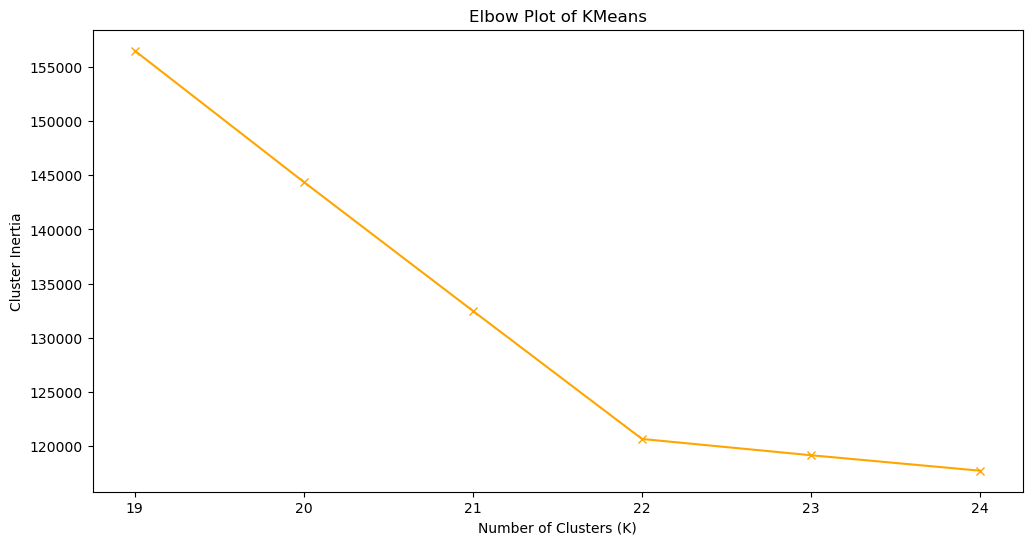

In [118]:
inertias = []
K = range(19, 25)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)

# Plotting the results
figure = plt.subplots(figsize = (12, 6))

plt.plot(K, inertias, 'bx-', color = 'orange')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cluster Inertia")
plt.title("Elbow Plot of KMeans")
plt.show()

In [119]:
k = 22  # Choose an appropriate value based on the elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_scaled)

KMeans(n_clusters=22, random_state=42)

In [120]:
df_cluster['cluster'] = kmeans.labels_
df_cluster.head()

,income,days in hospital,municipality_Albertslund,municipality_Ballerup,municipality_Brøndby,municipality_Copenhagen,municipality_Denmark,municipality_Dragør,municipality_Frederiksberg,municipality_Furesø,...,ethnicity_Danish,ethnicity_Immigrants and descendants,ethnicity_Non-western immigrants and descendants,age_30-39,age_40-49,age_50-59,age_60-65,education_Higher education,education_No higher education,cluster
6,271510.362,0.215,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,3
7,218419.246,0.386,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,3
8,220190.110,0.202,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,3
9,169031.486,0.359,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,1,3
10,190374.958,0.266,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,1,0,3


In [121]:
cluster_sizes = df_cluster['cluster'].value_counts()
print(cluster_sizes)

3     700
2     672
19    672
20    640
8     606
9     585
12    574
7     562
4     557
1     536
0     527
6     522
13    497
16    495
21    473
15    464
11    457
10    435
18    435
17    373
5     328
14    210
Name: cluster, dtype: int64


In [122]:
# Create a DataFrame with the scaled data
data_scaled_df = pd.DataFrame(df_cluster, columns=df_cluster.columns)

# Add the cluster labels
data_scaled_df['cluster'] = kmeans.labels_

# Calculate the cluster centroids in the scaled data
centroids_scaled = data_scaled_df.groupby('cluster').mean().reset_index()

# Transform the centroids back to the original data scale
centroids = scaler.inverse_transform(centroids_scaled.drop('cluster', axis=1))

# Create a DataFrame with the original-scale centroids
centroids_df = pd.DataFrame(centroids, columns=df_cluster.columns[:-1])
print(centroids_df)

          income  days in hospital  municipality_Albertslund  \
0   2.394972e+10          1.297043                  0.041784   
1   2.045857e+10          1.303110                  0.041784   
2   1.854801e+10          1.457258                  0.041784   
3   1.964403e+10          1.388581                  0.041784   
4   1.981951e+10          1.365180                  0.041784   
5   2.334135e+10          1.279611                  0.041784   
6   2.789215e+10          1.273121                  0.041784   
7   1.958949e+10          1.353851                  0.041784   
8   2.061508e+10          1.341360                  0.041784   
9   1.898281e+10          1.377211                  0.041784   
10  2.033096e+10          1.315188                  0.041784   
11  2.331315e+10          1.237613                  0.041784   
12  2.874237e+10          1.270711                  0.041784   
13  1.987285e+10          1.296545                  0.041784   
14  2.822409e+10          1.406836      

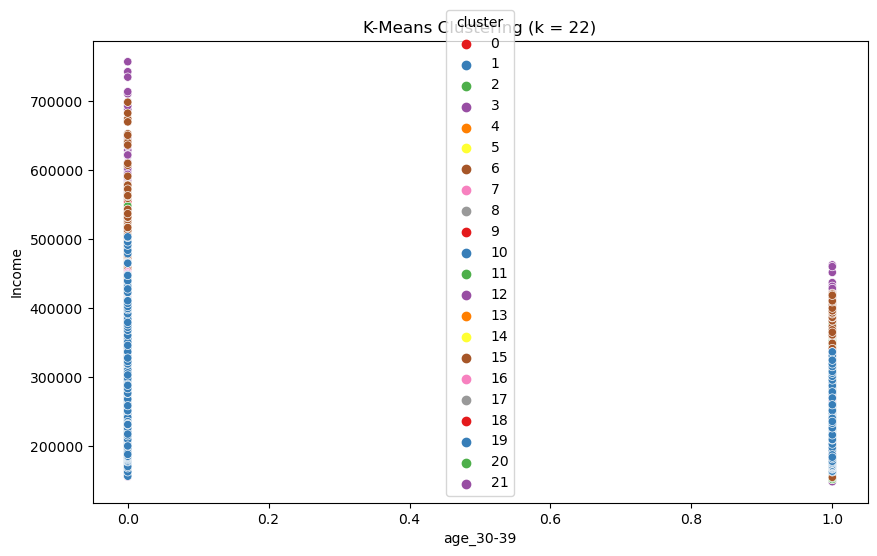

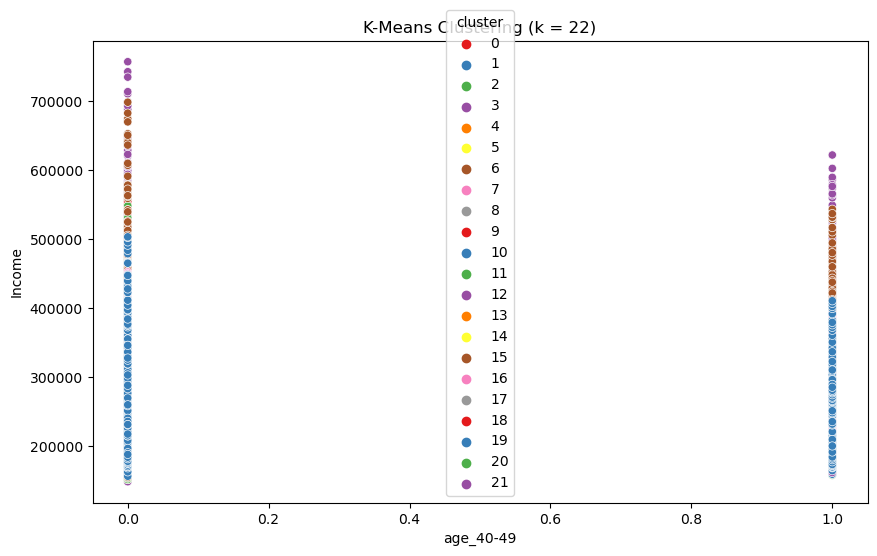

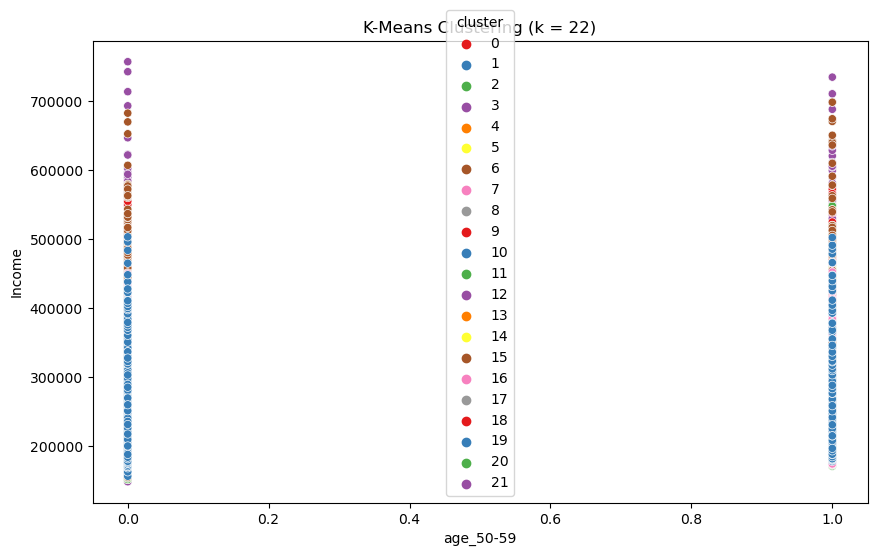

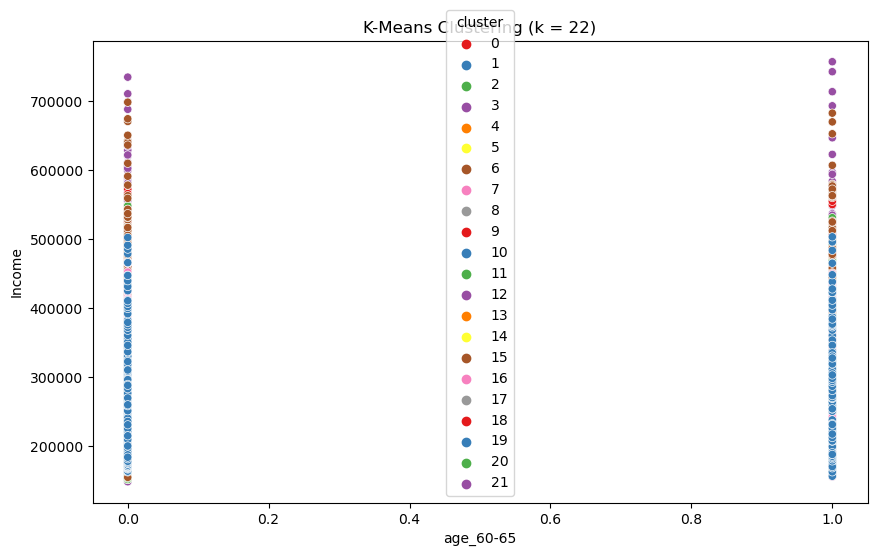

In [124]:
# Create a list of age group column names to loop through
age_cols = ['age_30-39', 'age_40-49', 'age_50-59', 'age_60-65']

# Loop through the age group columns and create scatter plots for each one
for age_col in age_cols:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=age_col, y='income', hue='cluster', data=df_cluster, palette='Set1')
    plt.xlabel(age_col)
    plt.ylabel('Income')
    plt.title('K-Means Clustering (k = {})'.format(k))
    plt.show()

In [125]:
# Calculate the cluster centroids in the scaled data
centroids_scaled = data_scaled_df.groupby('cluster').mean().reset_index()

# Transform the centroids back to the original data scale
centroids = scaler.inverse_transform(centroids_scaled.drop('cluster', axis=1))

# Create a DataFrame with the original-scale centroids
centroids_df = pd.DataFrame(centroids, columns=df_cluster.columns[:-1])
print(centroids_df)

          income  days in hospital  municipality_Albertslund  \
0   2.394972e+10          1.297043                  0.041784   
1   2.045857e+10          1.303110                  0.041784   
2   1.854801e+10          1.457258                  0.041784   
3   1.964403e+10          1.388581                  0.041784   
4   1.981951e+10          1.365180                  0.041784   
5   2.334135e+10          1.279611                  0.041784   
6   2.789215e+10          1.273121                  0.041784   
7   1.958949e+10          1.353851                  0.041784   
8   2.061508e+10          1.341360                  0.041784   
9   1.898281e+10          1.377211                  0.041784   
10  2.033096e+10          1.315188                  0.041784   
11  2.331315e+10          1.237613                  0.041784   
12  2.874237e+10          1.270711                  0.041784   
13  1.987285e+10          1.296545                  0.041784   
14  2.822409e+10          1.406836      

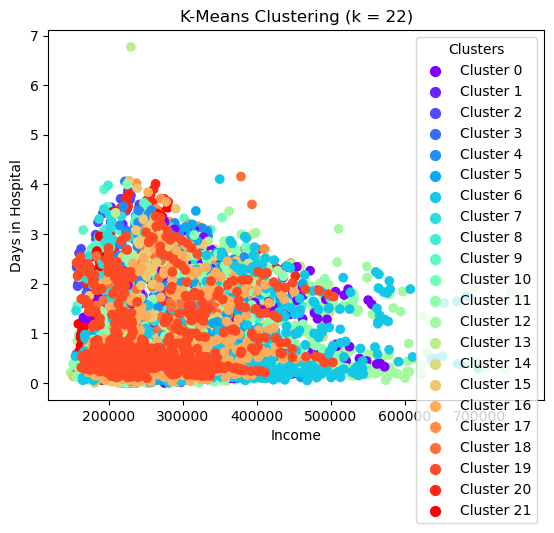

In [127]:
# Create a dictionary that maps each cluster label to a unique color
colors = cm.rainbow(np.linspace(0, 1, k))
color_dict = {i: colors[i] for i in range(k)}

# Plot the scatter plot with color and cluster labels
plt.scatter(df_cluster["income"], df_cluster["days in hospital"], c=df_cluster["cluster"], cmap=cm.rainbow)
plt.xlabel("Income")
plt.ylabel("Days in Hospital")
plt.title("K-Means Clustering (k = {})".format(k))

# Add a legend with color and cluster labels
legend_elements = [plt.scatter([], [], marker="o", s=50, color=color_dict[i], label="Cluster {}".format(i)) for i in range(k)]
plt.legend(handles=legend_elements, title="Clusters")

# # Add cluster labels
# for i, row in df_cluster.iterrows():
#     plt.text(row["income"], row["days in hospital"], str(row["cluster"]), color="black")

plt.show()